In [2]:

!pip install gymnasium shimmy stable-baselines3[extra] matplotlib swig
!pip install "gymnasium[box2d]"


from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:

import gymnasium as gym
import os
from datetime import datetime, timedelta
from gymnasium.wrappers import RecordVideo
from stable_baselines3 import SAC
import shutil
import matplotlib.pyplot as plt
from stable_baselines3.common.callbacks import BaseCallback
import numpy as np
import time


video_folder = "/content/drive/My Drive/RL"
os.makedirs(video_folder, exist_ok=True)


timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
video_filename = f"rl-video-{timestamp}.mp4"
video_file_path = os.path.join(video_folder, video_filename)


ENV_NAME = "BipedalWalker-v3"


env = RecordVideo(
    gym.make(ENV_NAME, render_mode="rgb_array", max_episode_steps=200000),
    video_folder=video_folder,
    episode_trigger=lambda episode_id: True
)
print(f"Video will be saved to: {video_file_path}")
print(f"Testing Environment: {ENV_NAME}")


<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyPacked has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyObject has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type swigvarlink has no __module__ attribute


Video will be saved to: /content/drive/My Drive/RL/rl-video-20241211_134126.mp4
Testing Environment: BipedalWalker-v3


/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

In [4]:

class RewardCallback(BaseCallback):
    def __init__(self, total_timesteps, verbose=0):
        super(RewardCallback, self).__init__(verbose)
        self.episode_rewards = []
        self.total_timesteps = total_timesteps
        self.start_time = None

    def _on_training_start(self):
        self.start_time = time.time()

    def _on_step(self):

        if 'episode' in self.locals['infos'][0]:
            self.episode_rewards.append(self.locals['infos'][0]['episode']['r'])


        elapsed_time = time.time() - self.start_time
        steps_completed = self.num_timesteps
        remaining_steps = self.total_timesteps - steps_completed
        eta_seconds = (elapsed_time / steps_completed) * remaining_steps if steps_completed > 0 else 0
        eta = str(timedelta(seconds=int(eta_seconds)))
        print(f"Steps completed: {steps_completed}/{self.total_timesteps}, ETA: {eta}", end="\r")
        return True


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_file_name = f"sac_{ENV_NAME}_{timestamp}.zip"
model_file_path = os.path.join(video_folder, model_file_name)

model = SAC(
    "MlpPolicy",
    env,
    verbose=1,
    batch_size=256,
    buffer_size=200000
)


reward_callback = RewardCallback(total_timesteps=200000)


model.learn(total_timesteps=200000, log_interval=10, callback=reward_callback)

model.save(model_file_path)
print(f"Model saved to: {model_file_path}")


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/moviepy/config_defaults.py:1: DeprecationWarning: invalid escape sequence '\P'
  """


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.92e+03 |
|    ep_rew_mean     | -172     |
| time/              |          |
|    episodes        | 10       |
|    fps             | 36       |
|    time_elapsed    | 522      |
|    total_timesteps | 19188    |
| train/             |          |
|    actor_loss      | -19.4    |
|    critic_loss     | 0.161    |
|    ent_coef        | 0.00638  |
|    ent_coef_loss   | -1.85    |
|    learning_rate   | 0.0003   |
|    n_updates       | 19087    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -138     |
| time/              |          |
|    episodes        | 20       |
|    fps             | 36       |
|    time_elapsed    | 546      |
|    total_timesteps | 20036    |
| train/             |          |
|    actor_loss      | -18.8    |
|    critic_loss     | 0.291    |
|    ent_coef 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


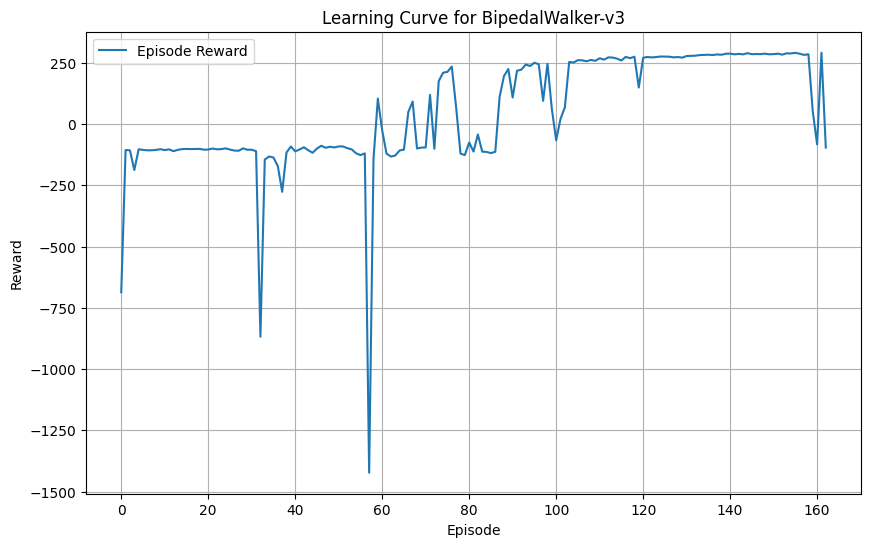

Learning curve saved to: /content/drive/My Drive/RL/learning_curve3.png


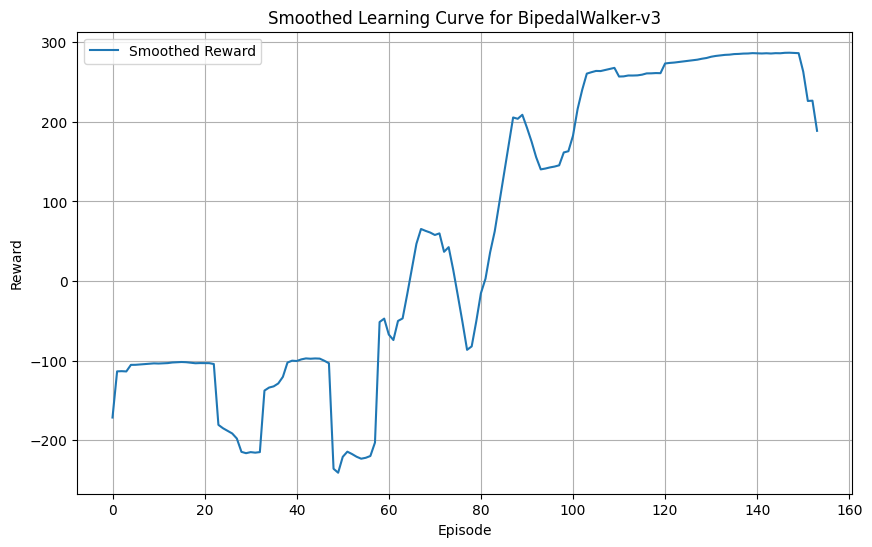

In [6]:

plt.figure(figsize=(10, 6))
plt.plot(reward_callback.episode_rewards, label='Episode Reward')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title(f'Learning Curve for {ENV_NAME}')
plt.legend()
plt.grid()

video_folder = "/content/drive/My Drive/RL"
save_path = f"{video_folder}/learning_curve3.png"
plt.savefig(save_path, dpi=300)
plt.show()

print(f"Learning curve saved to: {save_path}")


def smooth(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

smoothed_rewards = smooth(reward_callback.episode_rewards, window_size=10)


plt.figure(figsize=(10, 6))
plt.plot(smoothed_rewards, label='Smoothed Reward')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title(f'Smoothed Learning Curve for {ENV_NAME}')
plt.legend()
plt.grid()
plt.show()


In [7]:

model = SAC.load(model_file_path)
obs, info = env.reset()


for _ in range(200000):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    if done or truncated:
        obs, info = env.reset()

env.close()


video_files = sorted([f for f in os.listdir(video_folder) if f.endswith(".mp4")])
if video_files:
    original_video_path = os.path.join(video_folder, video_files[-1])
    print("Generated video path (default):", original_video_path)

    shutil.move(original_video_path, video_file_path)
    print("Renamed video path:", video_file_path)
else:
    print("No video files found in folder.")


KeyboardInterrupt: 

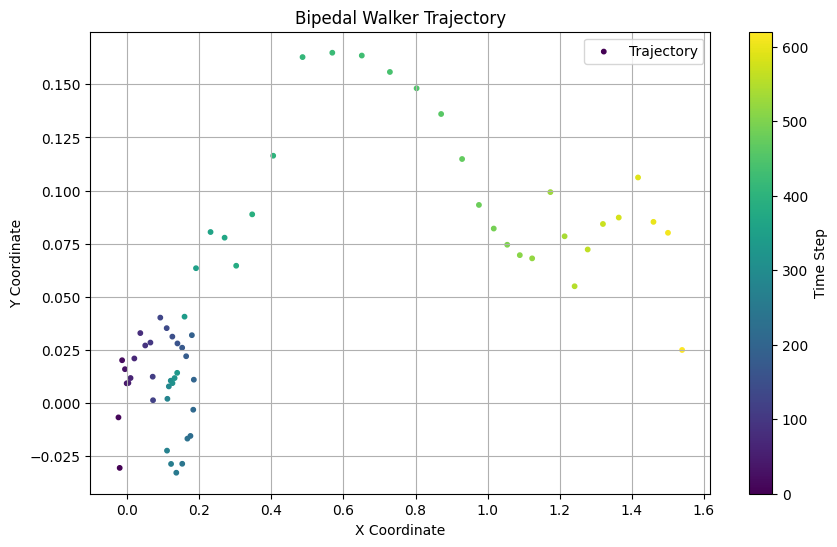

In [13]:



obs, info = env.reset()
states = []
colors = []

for step in range(0, 100000, 10):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    x, y = obs[0], obs[1]
    states.append((x, y))
    colors.append(step)
    if done or truncated:
        break

states = np.array(states)


plt.figure(figsize=(10, 6))
plt.scatter(states[:, 0], states[:, 1], c=colors, cmap="viridis", s=10, label="Trajectory")
plt.colorbar(label="Time Step")
plt.title("Bipedal Walker Trajectory")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()
plt.grid()
plt.show()

